# NLP Project - A.A. 2024/25

Authors:

- Gigante Davide (11018245)
- Puccia Niccolò (10829496)
- Sichili Giulio (11016179)
- Troiano Alessandro (10776474)

Link to the recording: AAAA

# Multimodal Question Answering: ScienceQA

# 0. Introduction

The dataset under study is **ScienceQA**, introduced in the NeurIPS 2022 paper *Learn to Explain: Multimodal Reasoning via Thought Chains for Science Question Answering*. ScienceQA is a large-scale benchmark designed to evaluate and improve the reasoning capabilities of AI systems on scientific multiple-choice questions.

This dataset is notable for its **multimodal** structure and its emphasis on **explainability** through annotated lectures and explanations that form a *chain-of-thought* (CoT). Unlike many previous benchmarks, which rely purely on textual information or offer limited domain coverage, ScienceQA includes:

* Over **21,000 examples**, each comprising a question, a set of answer choices, and a correct answer.
* **Multimodal contexts**, including both images and text passages.
* **Lectures** that provide general domain knowledge relevant to the question.
* **Explanations** that guide the reasoning process toward the correct answer.

Each question is mapped to a structured educational hierarchy that includes:

* **Grade level** (K–12),
* **Subject** (e.g., natural science, social science, language science),
* **Topic**, **Category**, and **Skill** fields, reflecting increasing specificity.

This rich annotation allows the dataset to support detailed analysis of both performance and reasoning quality, making it a valuable resource for developing interpretable and data-efficient QA models.



### Suppress Warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

### Install Dependencies

In [2]:
!pip install --upgrade gensim
!pip install datasets
!pip install wordcloud
!pip install -U datasets

### Import Libraries

In [57]:
from datasets import load_dataset
from datasets import concatenate_datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import mode
import re
import string
from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import statistics as _st # Maybe Useless
from itertools import islice
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import plotly.express as px

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


### Load Data

In [5]:
ds = load_dataset("derek-thomas/ScienceQA")

README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

(…)-00000-of-00001-1028f23e353fbe3e.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

(…)-00000-of-00001-6c7328ff6c84284c.parquet:   0%|          | 0.00/126M [00:00<?, ?B/s]

(…)-00000-of-00001-f0e719df791966ff.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 12726
    })
    validation: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
    test: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
})

In [7]:
def print_dataset_info(name, dataset):
    print(f"\n{name.upper()} DATASET")
    print(f"{'-'*len(name + ' DATASET')}")
    print(f"Number of examples: {len(dataset)}")
    print(f"Features: {dataset.column_names}")

# Data Subdivision
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']
full_ds = concatenate_datasets([train_ds, val_ds, test_ds])

# Print Dataset Information
print_dataset_info("Full", full_ds)
print_dataset_info("Train", train_ds)
print_dataset_info("Validation", val_ds)
print_dataset_info("Test", test_ds)


FULL DATASET
------------
Number of examples: 21208
Features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution']

TRAIN DATASET
-------------
Number of examples: 12726
Features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution']

VALIDATION DATASET
------------------
Number of examples: 4241
Features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution']

TEST DATASET
------------
Number of examples: 4241
Features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution']


### Exploring Data Types

In [11]:
def print_feature_types(name, dataset):
    print(f"\n{name.upper()} DATASET")
    print(f"{'-'*len(name + ' DATASET')}")
    print("Feature types:")
    for feature_name, feature_type in dataset.features.items():
        print(f"  - {feature_name:<10} : {feature_type}")

print_feature_types("Full", train_ds)


FULL DATASET
------------
Feature types:
  - image      : Image(mode=None, decode=True, id=None)
  - question   : Value(dtype='string', id=None)
  - choices    : Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
  - answer     : Value(dtype='int8', id=None)
  - hint       : Value(dtype='string', id=None)
  - task       : Value(dtype='string', id=None)
  - grade      : Value(dtype='string', id=None)
  - subject    : Value(dtype='string', id=None)
  - topic      : Value(dtype='string', id=None)
  - category   : Value(dtype='string', id=None)
  - skill      : Value(dtype='string', id=None)
  - lecture    : Value(dtype='string', id=None)
  - solution   : Value(dtype='string', id=None)


As we can see, our dataset is composed of several fields, each serving a distinct role in structuring the question-answering task. Below is a detailed description of every feature, reflecting both its data type and its intended semantic function:

* **image**
  `Image(mode=None, decode=True, id=None)`
  Represents a contextual image that accompanies the question. This visual input may provide additional information necessary for interpreting the question or supporting the reasoning process.

* **question**
  `Value(dtype='string', id=None)`
  A natural-language prompt derived from the associated lecture content. It defines the main inquiry that the user must address.

* **choices**
  `Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)`
  A sequence of textual answer options. These choices represent possible responses to the question, among which only one is correct.

* **answer**
  `Value(dtype='int8', id=None)`
  An integer index pointing to the correct choice within the `choices` sequence. This serves as the ground-truth label for supervised learning tasks.

* **hint**
  `Value(dtype='string', id=None)`
  A supplementary piece of information designed to assist in solving the question. It does not directly provide the answer but helps guide the reasoning.

* **task**
  `Value(dtype='string', id=None)`
  A brief description of the nature of the activity being asked of the user, such as classification, comparison, or inference.

* **grade**
  `Value(dtype='string', id=None)`
  Indicates the educational level for which the question is intended, formatted as a string (e.g., "Grade 5"). This allows for curriculum alignment and difficulty scaling.

* **subject**
  `Value(dtype='string', id=None)`
  Specifies the broad academic domain relevant to the question, such as "Science," "Mathematics," or "Language."

* **topic**
  `Value(dtype='string', id=None)`
  Refines the `subject` field by denoting a specific thematic area, such as "natural-sciences," "social-science," or "language-science."

* **category**
  `Value(dtype='string', id=None)`
  A subdomain or subcategory of the given topic. This helps further narrow down the conceptual focus of the question.

* **skill**
  `Value(dtype='string', id=None)`
  Describes the cognitive skill or operation the user is expected to apply, such as "identify," "analyze," or "summarize."

* **lecture**
  `Value(dtype='string', id=None)`
  A text excerpt or lecture passage from which the question is derived. It provides the primary source of information or context.

* **solution**
  `Value(dtype='string', id=None)`
  A textual explanation outlining how the correct answer can be derived. This may include reasoning steps, calculations, or logical deductions.

# 1. Exploratory Data Analysis

In [9]:
def print_context_stats(name, dataset):
    header = f"{name.upper()} CONTEXT STATS"
    print(f"\n{header}")
    print(f"{'-' * len(header)}")
    image_count = 0
    hint_count = 0
    both_count = 0
    none_count = 0

    for ex in dataset:
        has_image = ex['image'] is not None
        has_hint  = bool(ex['hint'])

        if has_image:
            image_count += 1
        if has_hint:
            hint_count += 1
        if has_image and has_hint:
            both_count += 1
        if not has_image and not has_hint:
            none_count += 1

    print(f"Questions with images           : {image_count}")
    print(f"Questions with hints            : {hint_count}")
    print(f"Questions with both image+hints : {both_count}")
    print(f"Questions without any context   : {none_count}")

    return image_count, hint_count, both_count, none_count

image_count, text_count, context_count, none_count = print_context_stats("Full", full_ds)


FULL CONTEXT STATS
------------------
Questions with images           : 10332
Questions with hints            : 10220
Questions with both image+hints : 6532
Questions without any context   : 7188


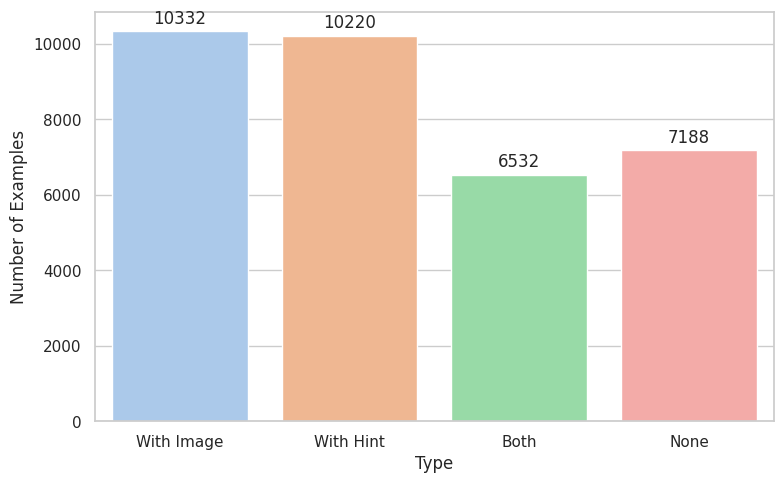

In [13]:
# Data to plot
labels = ['With Image', 'With Hint', 'Both', 'None']
counts = [image_count, text_count, context_count, none_count]

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Barplot
sns.barplot(x=labels, y=counts, palette='pastel')
plt.ylabel('Number of Examples')
plt.xlabel('Type')

# Annotate counts
for i, count in enumerate(counts):
    plt.text(i, count + max(counts)*0.02, str(count), ha='center')

plt.tight_layout()
plt.show()

## Plot Word Distribution

### Define Plotting Functions

In [23]:
def plot_feature_distribution(
    dataset, column, title, xlabel, rotation=60, palette='muted', sort_by_freq=True
):
    plt.figure(figsize=(14, 6))

    data_df = dataset.to_pandas()

    if sort_by_freq:
        order = data_df[column].value_counts().index
    else:
        order = dataset.unique(column)

    ax = sns.countplot(x=column, data=data_df, order=order, palette=palette)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Number of Questions")
    plt.xticks(rotation=rotation, ha='right')

    for p in ax.patches:
        ax.annotate(
            str(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom',
            fontsize=8, color='black',
            xytext=(0, 2),
            textcoords='offset points'
        )

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [56]:
def plot_length_distribution(
    dataset, text_column='question', title="Question Length Distribution", max_words=40, tick_interval=1
):
    data_df = dataset.to_pandas()
    data_df['question_length'] = data_df[text_column].apply(lambda q: len(q.split()))

    plt.figure(figsize=(14, 6))

    ax = sns.histplot(
        data_df['question_length'],
        bins=range(0, max_words + 1),
        kde=False,
        color='mediumseagreen',
        edgecolor='black'
    )

    plt.title(title)
    plt.xlabel(f"Number of Words in {text_column.capitalize()}")
    plt.ylabel("Frequency")
    plt.xticks(np.arange(0, max_words + 1, step=tick_interval))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [25]:
def plot_length_statistics(dataset, text_column='question', title='Question Length Stats', plot = False):
    df = dataset.to_pandas()
    df['question_length'] = df[text_column].apply(lambda q: len(q.split()))
    lengths = df['question_length']
    mean_len = np.mean(lengths)
    median_len = np.median(lengths)
    mode_len = mode(lengths, keepdims=True).mode[0]
    std_len = np.std(lengths)
    max_len = int(lengths.max())
    min_len = int(lengths.min())

    # Print statistics
    print(f"\n{title}")
    print("=" * len(title))
    print(f"Mean:   {mean_len:.2f} words")
    print(f"Median: {median_len} words")
    print(f"Mode:   {mode_len} words")
    print(f"Std:    {std_len:.2f} words")

    if plot:
      # Plot
      plt.figure(figsize=(16, 7))
      sns.set_style("whitegrid")
      sns.histplot(lengths, binwidth=1, kde=True, color='#69b3a2', edgecolor='black', alpha=0.75)
      plt.xlim(left=min_len - 2, right=40)  # Stops x-axis at 40

      # Add lines + annotations
      y_max = plt.ylim()[1]
      for i, (val, label, color, style) in enumerate([
          (mean_len, f'Mean\n({mean_len:.2f})', '#e41a1c', '--'),    # red
          (median_len, f'Median\n({int(median_len)})', '#377eb8', '-.'),  # blue
          (mode_len, f'Mode\n({int(mode_len)})', '#4daf4a', ':'),     # green
      ]):
          plt.axvline(val, color=color, linestyle=style, linewidth=2)
          plt.text(val + 0.3, y_max * (0.85 - i * 0.1), label, color=color, fontsize=12, rotation=90, va='top')

      # Adjust x-axis
      buffer = 2
      plt.xlim(min_len - buffer, max_len + buffer)
      plt.xticks(np.arange(min_len, max_len + 1, step=max(1, (max_len - min_len) // 15)))

      plt.title(title, fontsize=16)
      plt.xlabel(f"Number of Words in {text_column.capitalize()}", fontsize=13)
      plt.ylabel("Frequency", fontsize=13)
      plt.grid(axis='y', linestyle='--', alpha=0.5)
      plt.tight_layout()
      plt.show()

In [31]:
def plot_question_length_pie(dataset, text_column='question', title="Question Length Distribution (Pie Chart)"):
    df = dataset.to_pandas()
    df['question_length'] = df[text_column].apply(lambda q: len(q.split()))

    # Definisci fasce di lunghezza
    bins = [0, 5, 10, 15, 20, 1000]
    labels = ['0–5 words', '6–10 words', '11–15 words', '16–20 words', '21+ words']
    df['length_group'] = pd.cut(df['question_length'], bins=bins, labels=labels, right=True)

    # Conta le occorrenze per fascia
    group_counts = df['length_group'].value_counts().sort_index()

    # Dati per il pie chart
    sizes = group_counts.values
    group_labels = group_counts.index.tolist()

    # Plot a torta con legenda
    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(
        sizes,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Pastel1.colors,
        textprops=dict(color="black")
    )

    # Aggiungi legenda esterna
    plt.legend(wedges, group_labels, title="Length Range", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.tight_layout()
    plt.show()


### Discuss Results

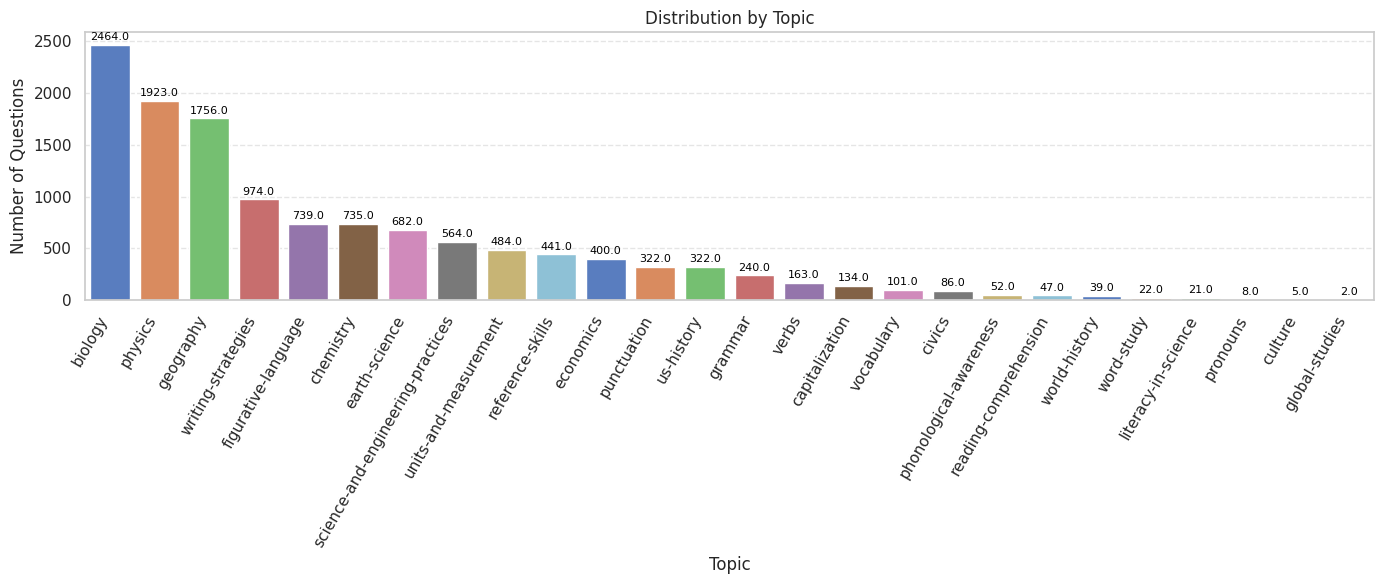

In [27]:
# topic class distribution
plot_feature_distribution(full_ds, column="topic", title="Distribution by Topic", xlabel="Topic")

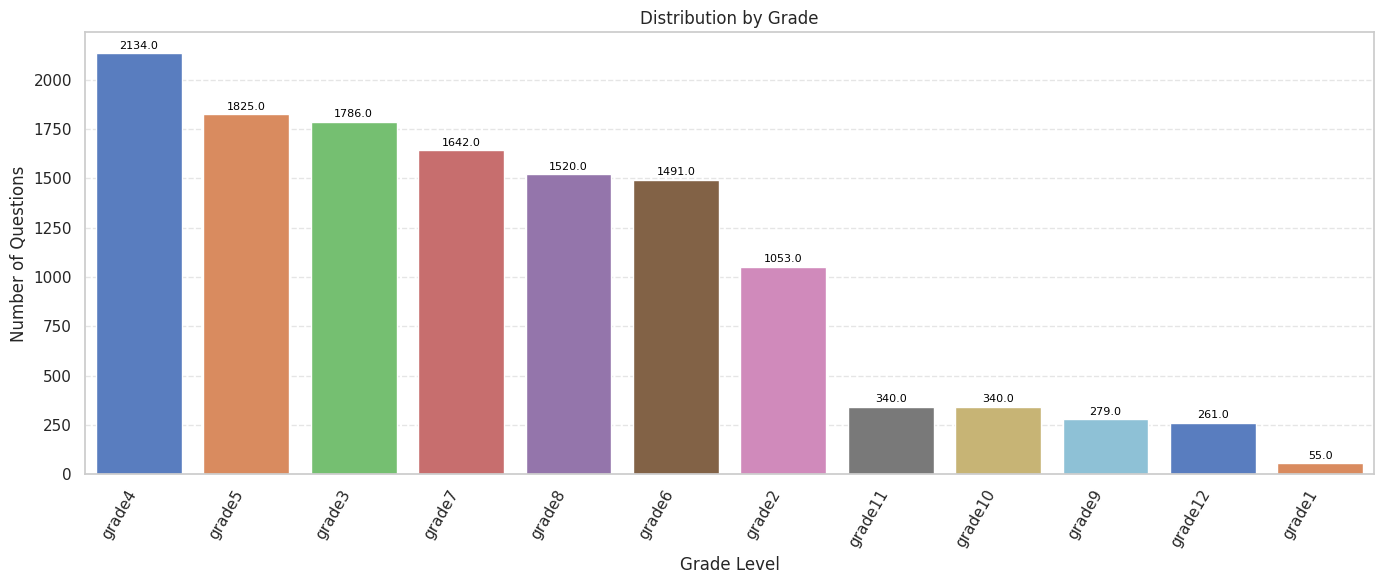

In [28]:
# grade level distribution
plot_feature_distribution(full_ds, column="grade", title="Distribution by Grade", xlabel="Grade Level")

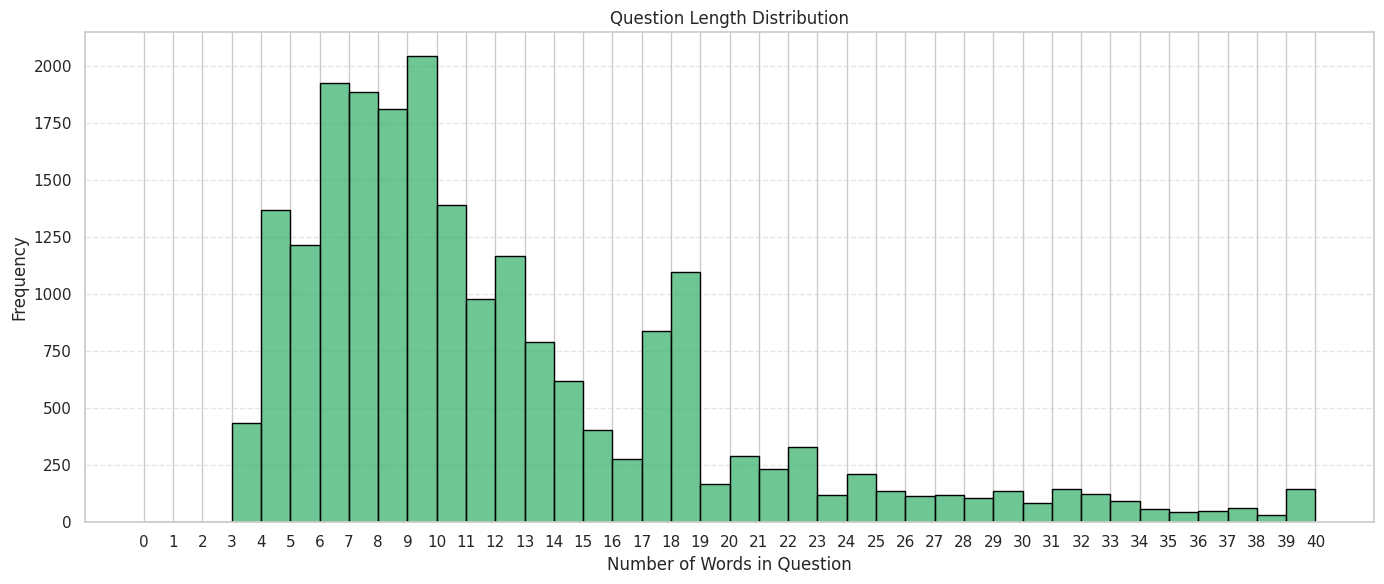

In [55]:
# question length histogram
plot_length_distribution(full_ds)

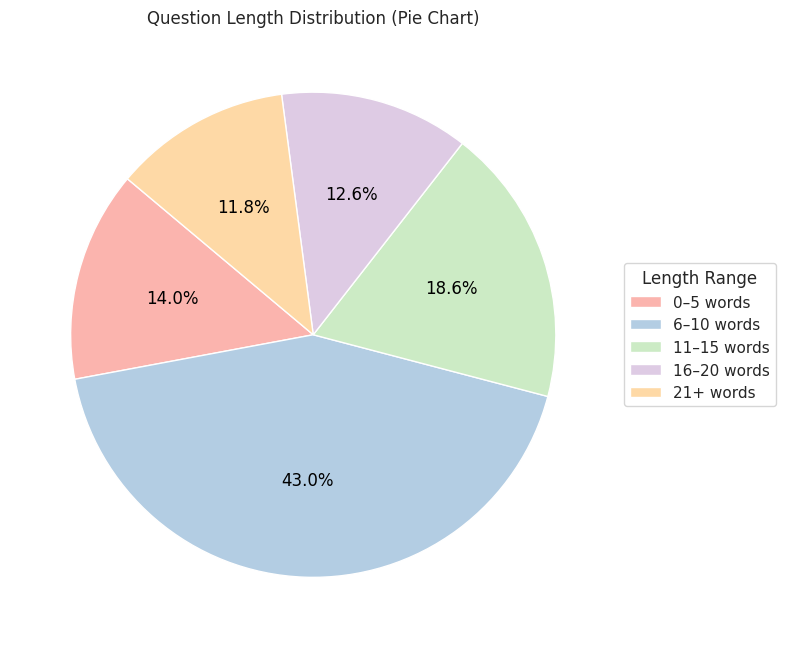

In [32]:
plot_question_length_pie(train_ds)

# 2. Data Preprocessing

### Cleaning utilities
Compiled objects live at module scope for maximum speed.



In [33]:
_PUNCT_RE   = re.compile(f"[{re.escape(string.punctuation)}]")
_STOP_WORDS = set(stopwords.words("english"))
_LEMMATIZER = WordNetLemmatizer()
_POS_MAP    = {"J": wordnet.ADJ, "V": wordnet.VERB, "N": wordnet.NOUN, "R": wordnet.ADV}

def _wn_pos(tag: str):
    """Map Penn‑Treebank tag to WordNet tag."""
    return _POS_MAP.get(tag[0], wordnet.NOUN)

def normalize_text(text: str) -> list[str]:
    """Lower‑case, strip punctuation & stop‑words, digit filter, lemmatise."""
    clean = _PUNCT_RE.sub("", text.lower())
    tokens = [t for t in word_tokenize(clean) if t.isalpha() and t not in _STOP_WORDS]
    tagged = pos_tag(tokens)
    return [_LEMMATIZER.lemmatize(w, _wn_pos(p)) for w, p in tagged]

### Combine textual fields
The five textual columns are concatenated into a single column through a parallel `map`.

In [35]:
TEXT_COLS = ["question", "choices", "hint", "lecture", "solution"]

def _concat(batch):
    out = []
    for q, ch, h, l, s in zip(batch["question"], batch["choices"], batch["hint"], batch["lecture"], batch["solution"]):
        joined_choices = " ".join(ch)  # choices is a list
        out.append(f"{q} {joined_choices} {h} {l} {s}")
    return {"combined_text": out}

full_ds = full_ds.map(_concat, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/21208 [00:00<?, ? examples/s]

### Normalisation pipeline
Adds two new columns: *tokens* (normalised) and *question_len*.

In [40]:
full_ds = full_ds.map(lambda x: {"tokens": normalize_text(x["combined_text"]),
                                 "question_len": len(x["question"].split())},
                      num_proc=4)

# For later use
QUESTION_LENS = full_ds["question_len"]

Map (num_proc=4):   0%|          | 0/21208 [00:00<?, ? examples/s]

### Word‑clouds at successive stages

#### Helper Function

In [43]:
def _plot_wc(freq: Counter, title: str):
    wc = WordCloud(width=900, height=450, background_color="white", max_words=250)
    img = wc.generate_from_frequencies(freq)
    plt.figure(figsize=(12, 6))
    plt.imshow(img, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

#### Word Cloud On Raw Text

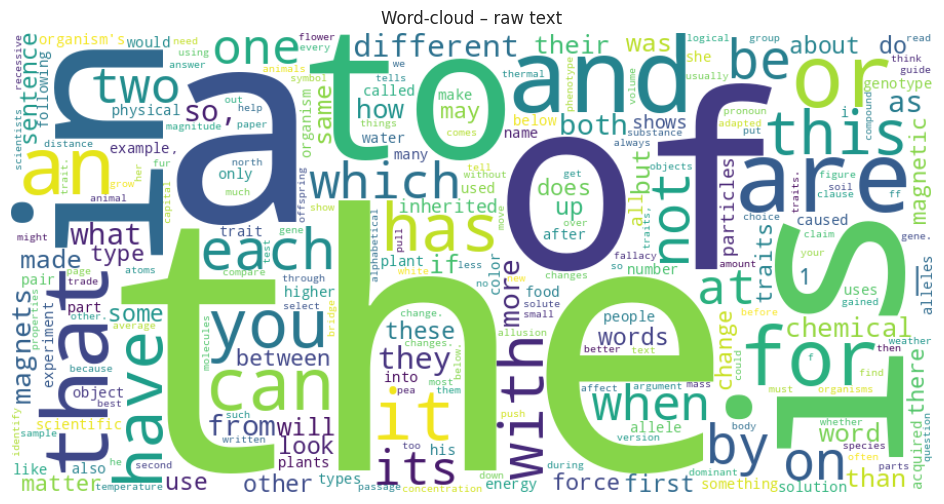

In [45]:
raw_corpus = " ".join(full_ds["combined_text"]).lower()
raw_freq   = Counter(raw_corpus.split())

_plot_wc(raw_freq,  "Word‑cloud – raw text")

####  Word Cloud After Stop‑word Removal

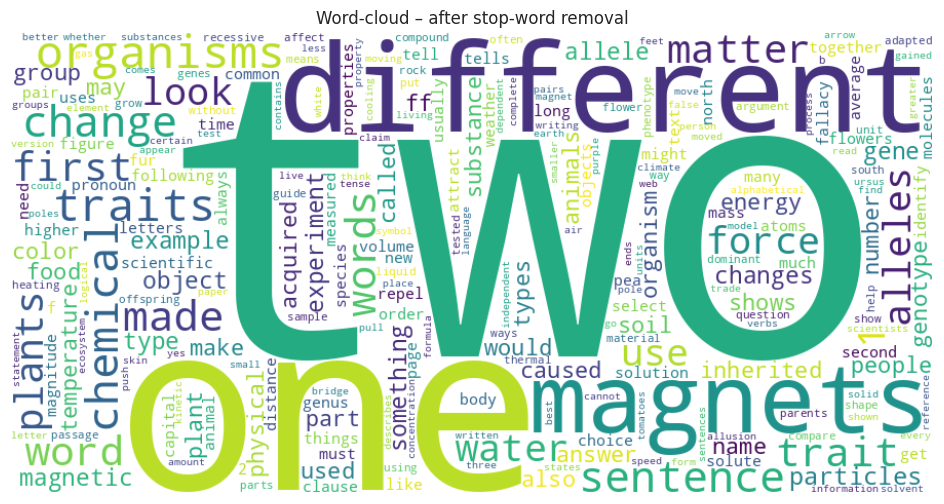

In [46]:
clean_sw   = _PUNCT_RE.sub("", raw_corpus)
no_sw_freq = Counter([w for w in clean_sw.split() if w not in _STOP_WORDS])

_plot_wc(no_sw_freq, "Word‑cloud – after stop‑word removal")

#### Word Cloud After Digit Removal & Lemmatisation

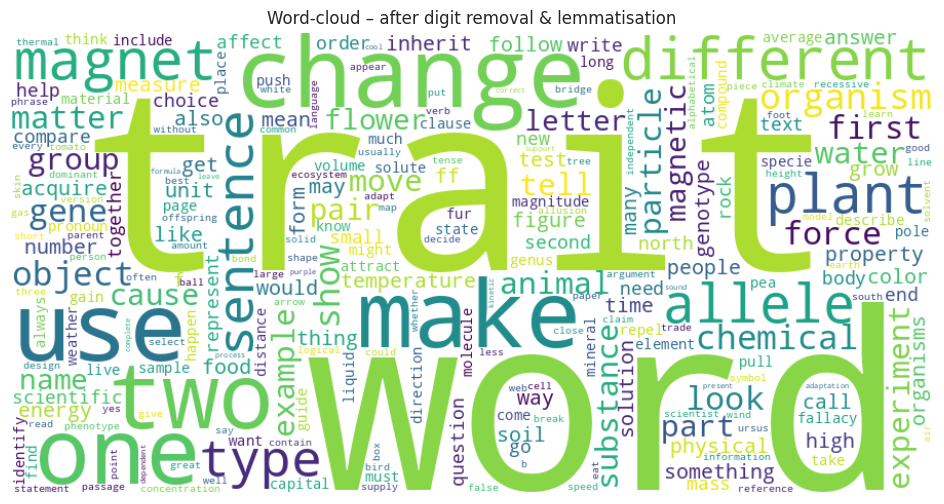

In [47]:
lemma_freq = Counter([tok for toks in full_ds["tokens"] for tok in toks])

_plot_wc(lemma_freq, "Word‑cloud – after digit removal & lemmatisation")

#### Column‑wise Word‑clouds

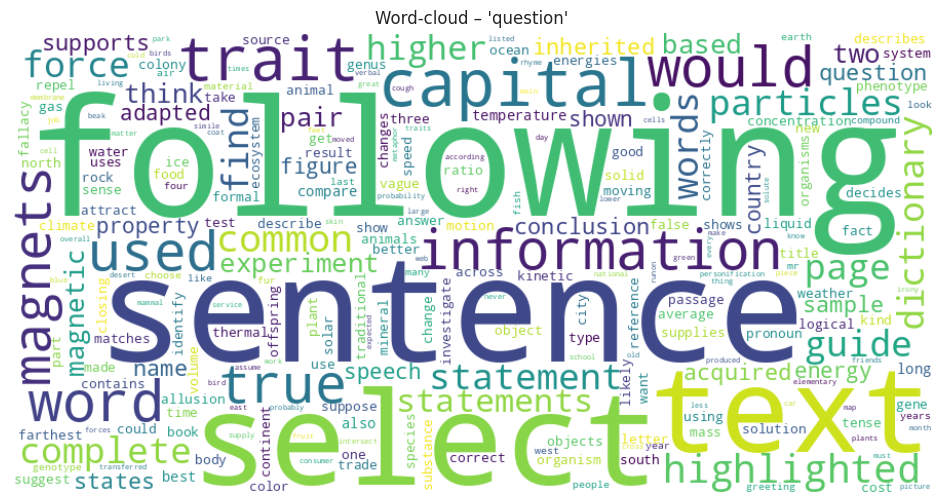

---------------------------------------------------------------------------------------------------------------------------


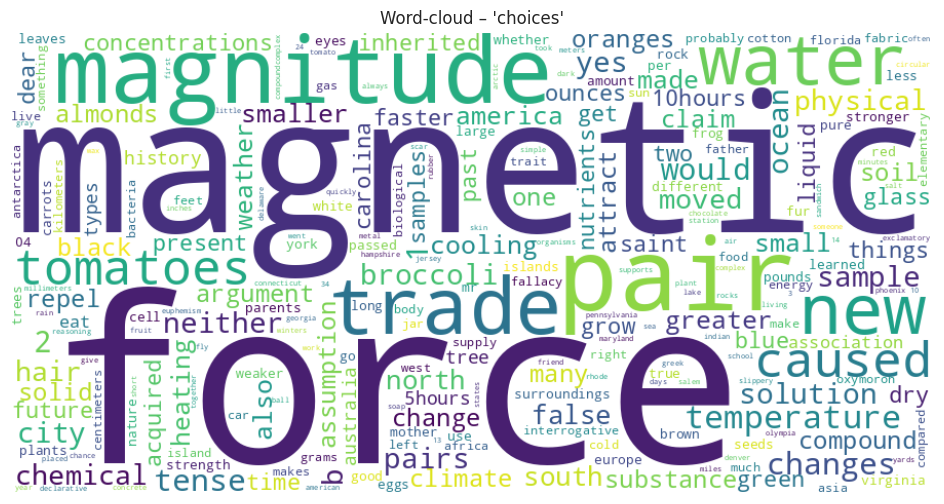

---------------------------------------------------------------------------------------------------------------------------


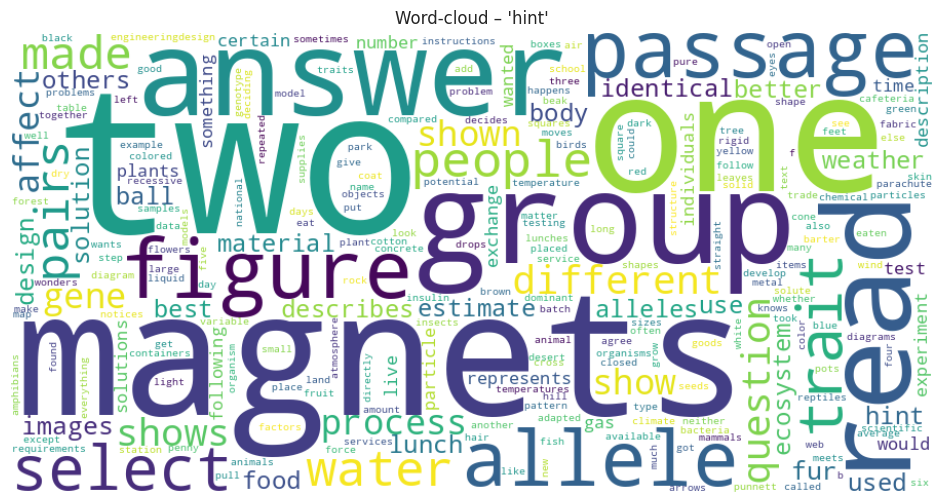

---------------------------------------------------------------------------------------------------------------------------


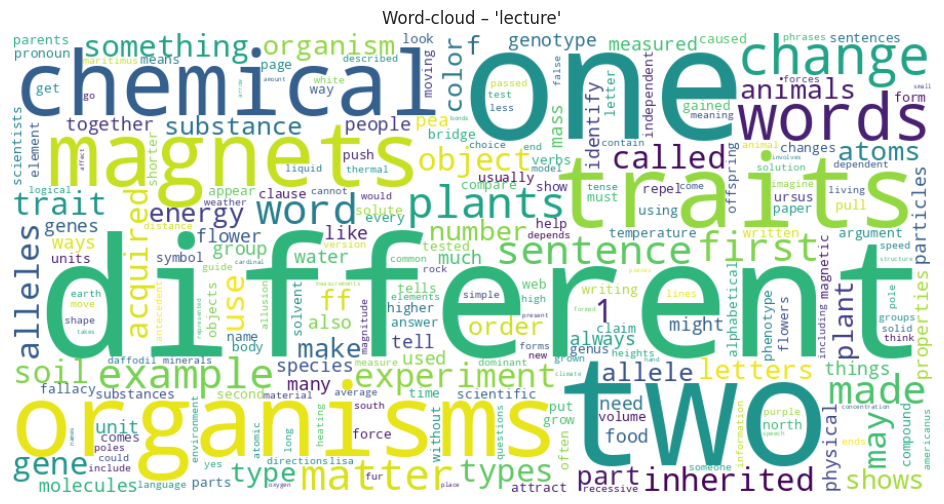

---------------------------------------------------------------------------------------------------------------------------


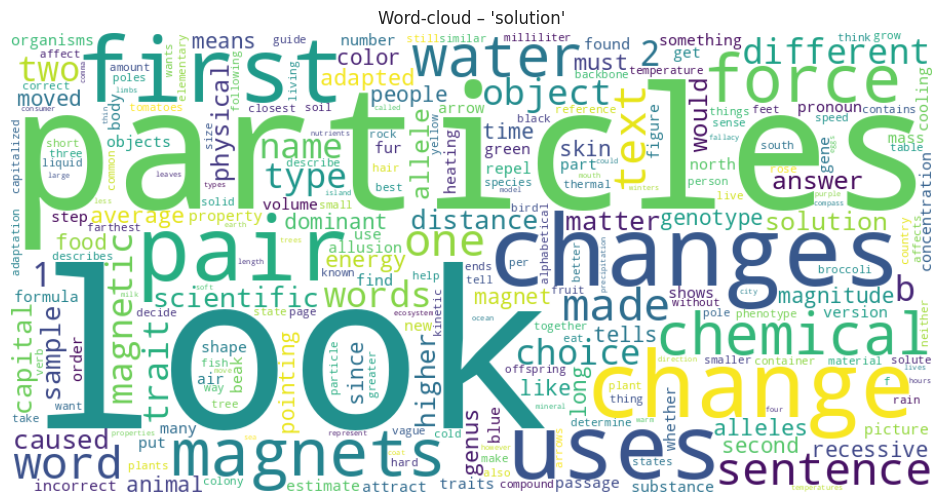

---------------------------------------------------------------------------------------------------------------------------


In [52]:
def _column_text(col: str):
    if col == "choices":
        rows = [" ".join(choices) for choices in full_ds[col]]
    else:
        rows = full_ds[col]
    return " ".join(rows).lower()

for col in TEXT_COLS:
    corpus_col = _PUNCT_RE.sub("", _column_text(col))
    freq_col   = Counter([w for w in corpus_col.split() if w not in _STOP_WORDS])
    _plot_wc(freq_col, f"Word‑cloud – '{col}'")
    print("-" * 123)

## N-grams Analysis

### Define Utility Function

In [78]:
def print_top_ngrams(
    tokens: list[str],
    top: int = 20,
    ngram: int = 1,
    title: str | None = None,
    sep: str = " "
) -> None:
    """
    Pretty-prints the most frequent n-grams.

    Parameters
    ----------
    tokens : list[str]
        Sequenza di token già normalizzati (stop-word rimosse, eventuale lemmatizzazione, ecc.).
    top : int, default = 20
        Numero di n-gram da mostrare.
    ngram : int, default = 1
        Dimensione dell’n-gram (1 = unigrammi, 2 = bigrammi…).
    title : str | None, default = None
        Titolo opzionale da visualizzare prima della tabella.
    sep : str, default = " "
        Separatore usato per concatenare i singoli token all’interno dell’n-gram.

    Output
    ------
    Stampa su stdout — formato tabellare: “Rank │ n-gram │ Freq”.
    """
    if ngram < 1:
        raise ValueError("ngram must be >= 1")

    # Construct N-grams through Sliding Window
    grams = [
        sep.join(tokens[i : i + ngram])
        for i in range(len(tokens) - ngram + 1)
    ]

    freq = Counter(grams)
    total = sum(freq.values())

    if title:
        line = title.upper()
        print(f"\n{line}\n{'-' * len(line)}")

    print(f"{'Rank':>4} │ {'n-gram':<{max(len(g) for g, _ in freq.most_common(top))}} │ {'Freq':>6} │ {'%':>6}")
    print("─" * 5, "┼", "─" *  max(12, max(len(g) for g, _ in freq.most_common(top))), "──┼", "─" * 8, "┼", "─" * 8, sep="")

    for idx, (gram, count) in enumerate(islice(freq.most_common(top), top), 1):
        percentage = count / total * 100
        print(f"{idx:>4} │ {gram:<{max(len(g) for g, _ in freq.most_common(top))}} │ {count:>6} │ {percentage:6.2f}")

In [60]:
all_tokens = [tok for tokens in full_ds["tokens"] for tok in tokens]

In [82]:
print_top_ngrams(all_tokens, top=25, ngram=2, title="Top 25 bigrams")


TOP 25 BIGRAMS
--------------
Rank │ n-gram             │   Freq │      %
─────┼────────────────────┼────────┼────────
   1 │ magnetic force     │   6761 │   0.31
   2 │ acquire trait      │   5406 │   0.25
   3 │ chemical change    │   4865 │   0.23
   4 │ scientific name    │   4383 │   0.20
   5 │ physical change    │   4266 │   0.20
   6 │ pea plant          │   3603 │   0.17
   7 │ magnitude magnetic │   3557 │   0.17
   8 │ chemical element   │   3218 │   0.15
   9 │ type matter        │   3119 │   0.14
  10 │ magnet attract     │   2920 │   0.14
  11 │ flower color       │   2887 │   0.13
  12 │ different type     │   2818 │   0.13
  13 │ guide word         │   2788 │   0.13
  14 │ thermal energy     │   2766 │   0.13
  15 │ inherit trait      │   2702 │   0.13
  16 │ alphabetical order │   2689 │   0.12
  17 │ first word         │   2676 │   0.12
  18 │ food web           │   2443 │   0.11
  19 │ plant grow         │   2276 │   0.11
  20 │ change cause       │   2272 │   0.11


## Word2Vec

In [ ]:
from gensim.utils import simple_preprocess

# Define text fields
text_columns = ['question', 'choices', 'hint', 'lecture', 'solution']

# Fill NaNs and convert to string
panda_df[text_columns] = panda_df[text_columns].fillna('')
panda_df[text_columns] = panda_df[text_columns].astype(str)

# Combine fields
panda_df['combined_text'] = panda_df[text_columns].agg(' '.join, axis=1)

# Remove empty or null combined_text
panda_df = panda_df[panda_df['combined_text'].notnull()]
panda_df = panda_df[panda_df['combined_text'].str.strip() != '']

# Apply gensim's simple_preprocess (lowercase, remove punctuation & short tokens)
sentences = panda_df['combined_text'].apply(lambda x: simple_preprocess(x, deacc=True)).tolist()

# Remove empty lists (some rows may be empty after tokenization)
sentences = [s for s in sentences if len(s) > 0]

# Check a sample
print(sentences[:2])


[['which', 'of', 'these', 'states', 'is', 'farthest', 'north', 'west', 'virginia', 'louisiana', 'arizona', 'oklahoma', 'maps', 'have', 'four', 'cardinal', 'directions', 'or', 'main', 'directions', 'those', 'directions', 'are', 'north', 'south', 'east', 'and', 'west', 'compass', 'rose', 'is', 'set', 'of', 'arrows', 'that', 'point', 'to', 'the', 'cardinal', 'directions', 'compass', 'rose', 'usually', 'shows', 'only', 'the', 'first', 'letter', 'of', 'each', 'cardinal', 'direction', 'the', 'north', 'arrow', 'points', 'to', 'the', 'north', 'pole', 'on', 'most', 'maps', 'north', 'is', 'at', 'the', 'top', 'of', 'the', 'map', 'to', 'find', 'the', 'answer', 'look', 'at', 'the', 'compass', 'rose', 'look', 'at', 'which', 'way', 'the', 'north', 'arrow', 'is', 'pointing', 'west', 'virginia', 'is', 'farthest', 'north'], ['identify', 'the', 'question', 'that', 'tom', 'and', 'justin', 'experiment', 'can', 'best', 'answer', 'do', 'ping', 'pong', 'balls', 'stop', 'rolling', 'along', 'the', 'ground', 'so

In [ ]:
model = Word2Vec(
    sentences,
    vector_size=100,     # embedding dimensions
    window=5,            # context window
    min_count=2,         # ignore very rare words
    workers=4,           # threads
    sg=1                 # use skip-gram; set to 0 for CBOW
)
print("The size of the vocabulary is:", len(model.wv))


The size of the vocabulary is: 13411


In [ ]:
term = 'magnet'
model.wv[term]

array([-0.98464197, -0.1841659 , -0.18789577,  0.65568733,  0.33821487,
       -0.12920365,  0.23664267, -0.47701314, -0.58502567,  0.08922148,
        0.54047453, -0.3606602 ,  0.06664941, -0.20193575,  0.92621034,
       -0.97227365, -0.7767152 , -0.55613685,  0.21258706,  0.07036929,
       -0.18100384,  0.18363133, -0.4123578 ,  0.6331597 ,  0.6846095 ,
       -0.43755007, -0.999876  , -1.3370873 ,  0.42817456,  0.47722277,
        0.25534382, -0.172473  ,  1.491797  ,  0.1109238 , -0.4126463 ,
        1.079424  , -0.57667875,  0.48429146, -0.8255586 , -0.35716942,
        0.26197672, -0.9146514 , -0.05742304,  0.3350785 ,  0.46129307,
        0.01419917, -0.30376846, -0.2890331 , -0.08402762, -0.0431603 ,
        0.47755894, -0.18595295, -0.45831665,  0.51289   ,  0.01326602,
       -0.18420841, -0.6783774 , -0.5086454 , -0.17997864,  0.58555895,
        0.6568587 , -0.0341645 ,  0.21857357, -0.11332283, -0.822733  ,
        1.0337772 ,  0.1322851 , -0.27414215, -0.10557047,  1.35

In [ ]:
model.wv.most_similar(term)

[('poles', 0.6840857863426208),
 ('magnets', 0.6468914747238159),
 ('attracts', 0.6402032375335693),
 ('closest', 0.6369199752807617),
 ('pole', 0.6271646022796631),
 ('disc', 0.6161269545555115),
 ('repels', 0.6073746681213379),
 ('mover', 0.5642837882041931),
 ('strollers', 0.5640946626663208),
 ('pairs', 0.5594373345375061)]

In [ ]:
#Embedding visualization

import random
from sklearn.decomposition import PCA

# Sample 100 words from your trained Word2Vec model
sample = random.sample(list(model.wv.key_to_index), 100)

# Extract vectors for sampled words
word_vectors = np.array([model.wv[word] for word in sample])

# Apply PCA
pca = PCA(n_components=3)
pca_embedding = pca.fit_transform(word_vectors)

# Split into coordinates
x, y, z = pca_embedding[:, 0], pca_embedding[:, 1], pca_embedding[:, 2]

# Create interactive 3D plot
fig = px.scatter_3d(
    x=x, y=y, z=z, text=sample,
    title="PCA of Word2Vec Embeddings",
)
fig.update_traces(marker=dict(size=4, line=dict(width=1)), textfont_size=10)
fig.show()



In [ ]:
# Anchor words
names = ['magnet', 'force', 'pole']

# Sample 100 random words (excluding anchor words)
sample = random.sample([w for w in model.wv.key_to_index if w not in names], 100)

# Combine known and sampled words
all_words = names + sample

# Get vectors
word_vectors = np.array([model.wv[word] for word in all_words])

# PCA projection
pca = PCA(n_components=3)
embedding = pca.fit_transform(word_vectors)
x, y, z = embedding[:, 0], embedding[:, 1], embedding[:, 2]

# Define zoomed-in 3D plot
fig = px.scatter_3d(
    x=x, y=y, z=z,
    text=names + [None] * len(sample),
    title="Zoomed-In PCA of Word2Vec Embeddings"
)

# Set camera closer to center and scale down axes range
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-15, 15]),
        yaxis=dict(range=[-15, 15]),
        zaxis=dict(range=[-15, 15]),
        camera=dict(
            eye=dict(x=0.7, y=0.7, z=0.5)  # closer perspective
        )
    )
)

fig.update_traces(marker=dict(size=3, line=dict(width=1)), textfont_size=10)
fig.show()

# 3. Extensions

## 3.1 RAG Voice Interactive Model

## 3.2 - Topic Classification

## 3.3 Topic Modelling